# Going Deeper -- the Mechanics of PyTorch 

In [2]:
from IPython.display import Image
%matplotlib inline

## Creating a graph in PyTorch

In [3]:
import torch

def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


## PyTorch Tensor objects for storing and updating model parameters

In [ ]:
# to make the parameters can be store and update in the gradient descent 
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True) 
print(a)
print(b)

In [ ]:
# use a classic radom initialization scheme
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

In [ ]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

## Computing gradients via automatic differentiation and GradientTape

### Computing the gradients of the loss with respect to trainable variables

In [5]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)
 
loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [ ]:
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

## Simplifying implementations of common architectures via the torch.nn module

### Implementing models based on nn.Sequential

In [ ]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

In [ ]:
# use l1 penalty to compute the weight of second layer
nn.init.xavier_uniform_(model[0].weight)
 
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [ ]:
# choose a SGD loss function
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Solving an XOR classification problem

XOR is a classic problem for analyzing the capacity of a model with regard to capturing the non-linear decision boundary between two classes. 

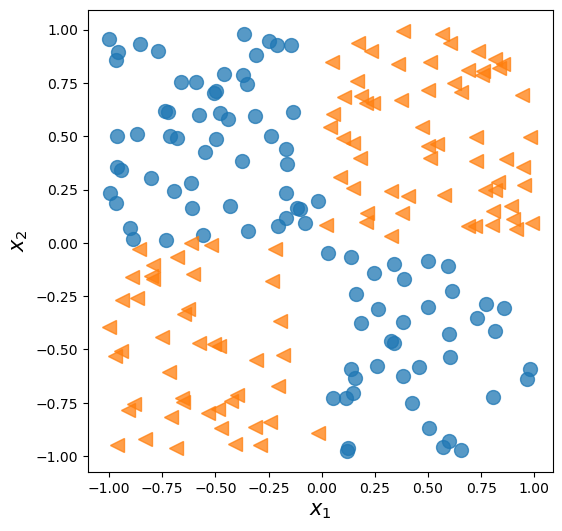

In [6]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

#plt.savefig('figures/13_02.png', dpi=300)
plt.show()

In [28]:
# define the model
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [29]:
# cross entropy loss function for binary classification and SGD
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [30]:
# create a dataloader that uses a batch size of 2 for the train data. 
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [31]:
# train the model for 200 epochs and record a history
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

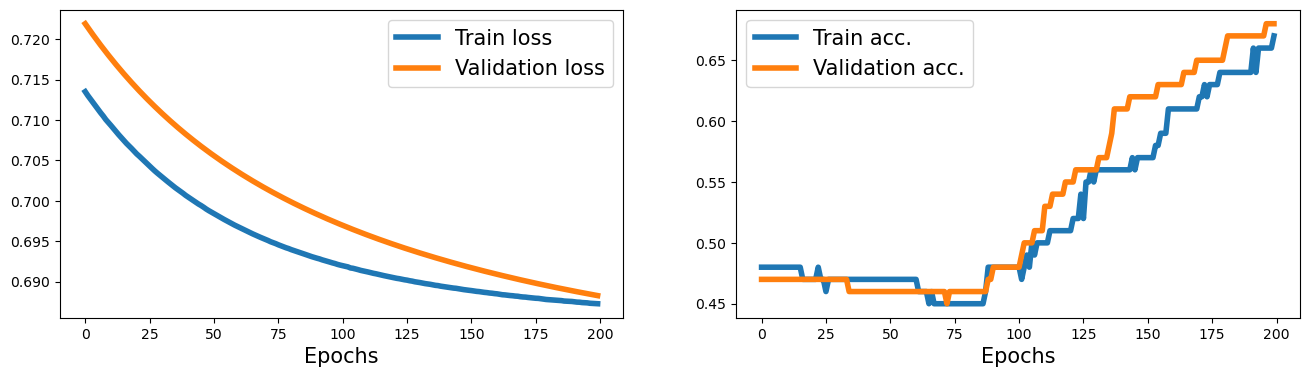

In [32]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

a simple model with no hidden layer cannot solve non linear problem. 

In [33]:
# add more layers
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [34]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

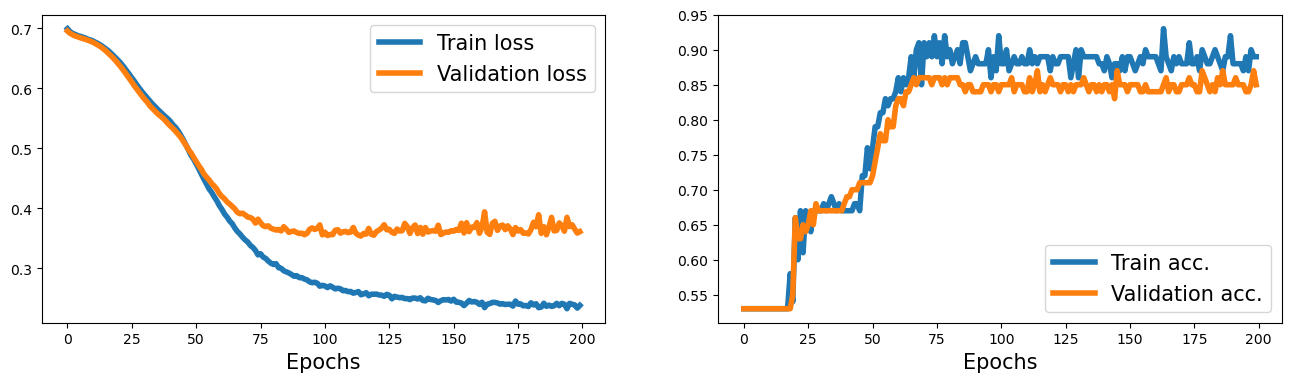

In [35]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_04.png', dpi=300)

## Making model building more flexible with nn.Module

nn.Module is more flexible and easy hands-on

In [36]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [37]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

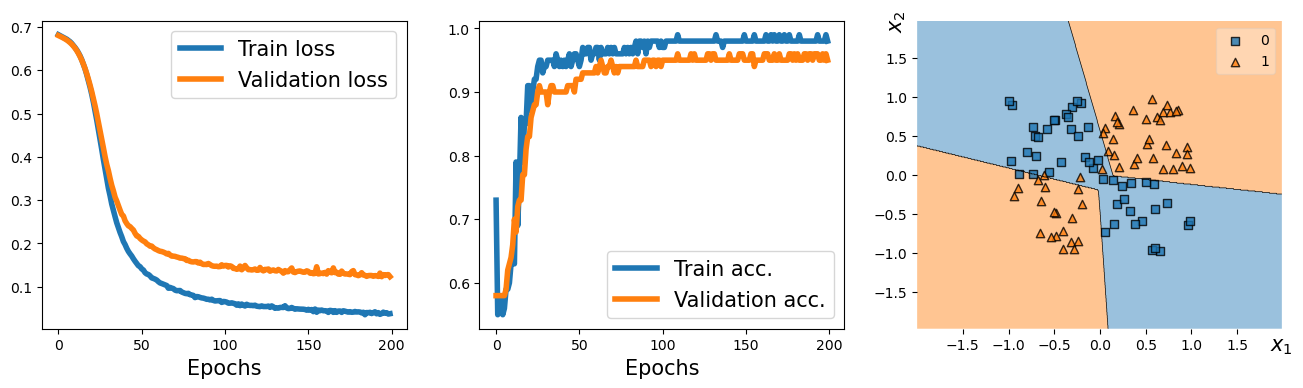

In [38]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

## Writing custom layers in PyTorch

In [46]:
# define a new layer called noisylinear
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)  

In [41]:
## testing:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))
 
print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [45]:
# use noisylinear as the first hidden layer
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [43]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

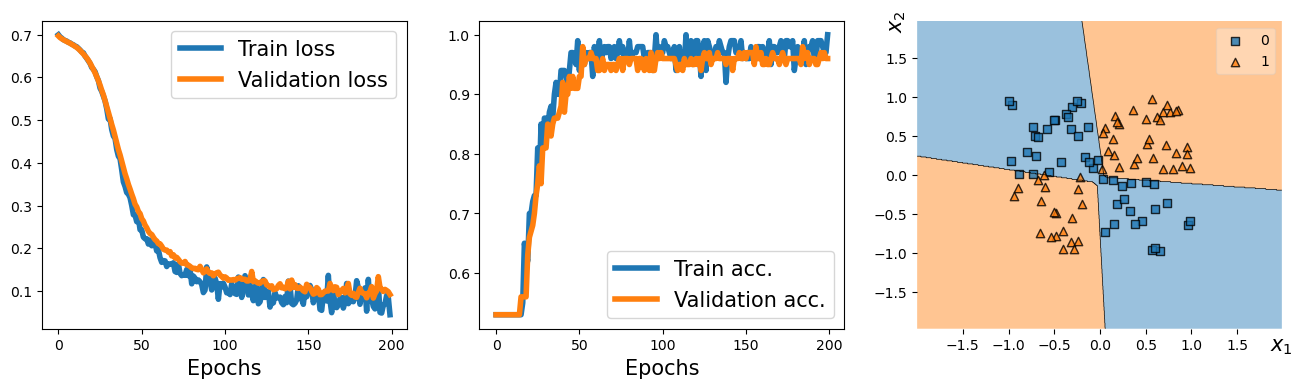

In [44]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()

# Project one - predicting the fuel efficiency of a car

In [48]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from IPython.display import Image

In [49]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [50]:
# remove NAN
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [52]:
# train/test split
import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [53]:
# standardiziing 

from packaging import version


numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()


if version.parse(pd.__version__) >= version.parse("2.0.0"):

    for col_name in numeric_column_names:
        mean = train_stats.loc[col_name, 'mean']
        std = train_stats.loc[col_name, 'std']
        df_train_norm[col_name] = (df_train_norm[col_name] - mean) / std
        df_test_norm[col_name] = (df_test_norm[col_name] - mean) / std

else:

    for col_name in numeric_column_names:
        mean = train_stats.loc[col_name, 'mean']
        std  = train_stats.loc[col_name, 'std']
        df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
        df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std
        
df_train_norm.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [54]:
# define boundaries
boundaries = torch.tensor([73, 76, 79])
 
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [55]:
# use one hot to label classes
from torch.nn.functional import one_hot


total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()
 
origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [56]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

#### train a DNN regression model 

In [60]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [61]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

model


Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [62]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [63]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20 
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')
 

Epoch 0  Loss 536.1047
Epoch 20  Loss 8.4361
Epoch 40  Loss 7.8695
Epoch 60  Loss 7.1891
Epoch 80  Loss 6.7062
Epoch 100  Loss 6.7599
Epoch 120  Loss 6.3124
Epoch 140  Loss 6.6864
Epoch 160  Loss 6.7648
Epoch 180  Loss 6.2156


In [64]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 9.6133
Test MAE: 2.1211


MAE: mean absolute error

## Project two - classifying MNIST hand-written digits

In [70]:
# loading dataset, define train and test dataset
import torchvision 
from torchvision import transforms 


image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)
 
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

In [67]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

Epoch 0  Accuracy 0.8531
Epoch 1  Accuracy 0.9287
Epoch 2  Accuracy 0.9413
Epoch 3  Accuracy 0.9506
Epoch 4  Accuracy 0.9558
Epoch 5  Accuracy 0.9592
Epoch 6  Accuracy 0.9627
Epoch 7  Accuracy 0.9650
Epoch 8  Accuracy 0.9674
Epoch 9  Accuracy 0.9690
Epoch 10  Accuracy 0.9710
Epoch 11  Accuracy 0.9729
Epoch 12  Accuracy 0.9739
Epoch 13  Accuracy 0.9750
Epoch 14  Accuracy 0.9764
Epoch 15  Accuracy 0.9777
Epoch 16  Accuracy 0.9779
Epoch 17  Accuracy 0.9798
Epoch 18  Accuracy 0.9806
Epoch 19  Accuracy 0.9813


In [69]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 
 

Test accuracy: 0.9647


## Higher-level PyTorch APIs: a short introduction to PyTorch Lightning

### Setting up the PyTorch Lightning model

In [1]:
import pytorch_lightning as pl
import torch 
import torch.nn as nn 

from torchmetrics import __version__ as torchmetrics_version
from pkg_resources import parse_version

from torchmetrics import Accuracy

In [14]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        
        # new PL attributes:
        
        if parse_version(torchmetrics_version) > parse_version("0.8"):
            self.train_acc = Accuracy(task="multiclass", num_classes=10)
            self.valid_acc = Accuracy(task="multiclass", num_classes=10)
            self.test_acc = Accuracy(task="multiclass", num_classes=10)
        else:
            self.train_acc = Accuracy()
            self.valid_acc = Accuracy()
            self.test_acc = Accuracy()
        
        # Model similar to previous section:
        input_size = image_shape[0] * image_shape[1] * image_shape[2] 
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units: 
            layer = nn.Linear(input_size, hidden_unit) 
            all_layers.append(layer) 
            all_layers.append(nn.ReLU()) 
            input_size = hidden_unit 
 
        all_layers.append(nn.Linear(hidden_units[-1], 10)) 
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self, outs):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self, outs):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

### Setting up the data loaders

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
 
from torchvision.datasets import MNIST
from torchvision import transforms

In [12]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        MNIST(root=self.data_path, download=True) 

    def setup(self, stage=None):
        # stage is either 'fit', 'validate', 'test', or 'predict'
        # here note relevant
        mnist_all = MNIST( 
            root=self.data_path,
            train=True,
            transform=self.transform,  
            download=False
        ) 

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST( 
            root=self.data_path,
            train=False,
            transform=self.transform,  
            download=False
        ) 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4)
    
    
torch.manual_seed(1) 
mnist_dm = MnistDataModule()

### Training the model using the PyTorch Lightning Trainer class

In [15]:
from pytorch_lightning.callbacks import ModelCheckpoint


mnistclassifier = MultiLayerPerceptron()

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(max_epochs=10, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=10)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\shuyu.liu\OneDrive - University of Florida\Desktop\ML Course\lightning_logs


AttributeError: module 'torch' has no attribute '_six'

### Evaluating the model using TensorBoard

In [ ]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')